# Artificial Neural Network From Scratch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
from sklearn.datasets import fetch_openml  #for the mnist dataset

## Preparing the Dataset

In [ ]:
#Alternatively the data could be read from kaggle as a csv using pandas but this method proves faster
mnist = fetch_openml('mnist_784')

In [3]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [4]:
data = mnist['data']
labels = mnist['target'].astype(np.int8)

In [68]:
data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Image Sample

In [5]:
np.random.seed(42)
n = np.random.choice(np.arange(data.shape[0]+1))
print(n)

15795


In [6]:
test_img= data.iloc[n].values
test_label = labels.iloc[n]
img_length = int(np.sqrt(test_img.shape))

C:\Users\rumes\AppData\Local\Temp\ipykernel_33660\2997330477.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img_length = int(np.sqrt(test_img.shape))


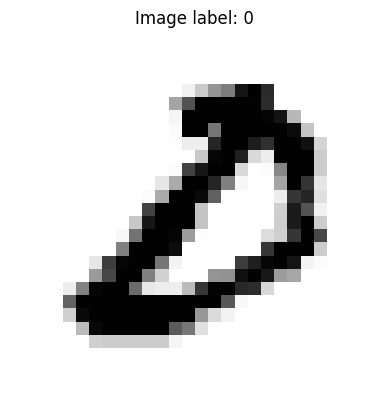

In [7]:
reshaped_img = test_img.reshape(img_length, img_length)
plt.imshow(reshaped_img, cmap='Greys')
plt.title(f"Image label: {test_label}")
plt.axis('off')
plt.show()

## Neural Network Class

In [8]:
class NeuralNetwork(object):
    def __init__(self, X: np.ndarray, y: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, activation: str, num_labels: int, architecture: list[int]):
        self.X = self.normalise(X).copy()
        assert np.all((self.X >= 0) & (self.X <= 1))
        self.X_test =self.normalise(X_test).copy()
        self.y = self.one_hot_encode(y, 10).T.copy()
        self.y_test = self.one_hot_encode(y_test, 10).T.copy()
        self.layers = {}
        self.architecture = architecture
        self.num_labels = num_labels
        self.activation_function = activation
        self.functions = {
            "relu": self.relu,
            "tanh": self.tanh,
            "sigmoid": self.sigmoid,
            "leaky_relu": self.leaky_relu
        }
        assert self.activation_function in self.functions
        self.parameters = {}
        self.m = X.shape[1]
        self.n = X.shape[0]
        assert self.X.shape == (self.n, self.m)
        assert self.y.shape == (self.num_labels, self.m)
        self.architecture.append(self.num_labels)
        self.architecture.insert(0, self.n)
        self.L = len(self.architecture)

    def relu(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(0, z)
    
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))
    
    def leaky_relu(self, z: np.ndarray) -> np.ndarray:
        return np.where(z > 0, z, z * 0.01)
    
    def tanh(self, z: np.ndarray) -> np.ndarray:
        return np.tanh(z)
    
    def softmax(self, z: np.ndarray) -> np.ndarray:
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def init_params(self):
        for i in range(1, self.L):
            self.parameters[f"w{i}"] = np.random.randn(self.architecture[i], self.architecture[i-1]) * np.sqrt(2.0/self.architecture[i-1])
            self.parameters[f"b{i}"] = np.zeros((self.architecture[i], 1))

    def normalise(self, x: np.ndarray) -> np.ndarray:
        return (x - np.min(x)) / (np.max(x) - np.min(x))
    
    def one_hot_encode(self, y: np.ndarray, num_labels: int) -> np.ndarray:
        return np.eye(num_labels)[y]

    def feed_forward(self):
        params = self.parameters
        self.layers["a0"] = self.X
        for l in range(1, self.L):
            self.layers[f"z{l}"] = np.dot(params[f"w{l}"], self.layers[f"a{l-1}"]) + params[f"b{l}"]
            if l == self.L - 1:
                self.layers[f"a{l}"] = self.softmax(self.layers[f"z{l}"])
            else:
                self.layers[f"a{l}"] = self.functions[self.activation_function](self.layers[f"z{l}"])
            assert self.layers[f"a{l}"].shape == (self.architecture[l], self.m)
        self.output = self.layers[f"a{self.L-1}"]
        epsilon = 1e-10
        cost = -np.sum(self.y * np.log(self.output + epsilon)) / self.m
        return cost, self.layers
    
    def derivative(self, activation_name, z):
        if activation_name == "relu":
            return (z > 0).astype(float)
        elif activation_name == "leaky_relu":
            dz = np.ones_like(z)
            dz[z < 0] = 0.01
            return dz
        elif activation_name == "tanh":
            return 1 - np.tanh(z)**2
        elif activation_name == "sigmoid":
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        else:
            raise ValueError("Unknown activation function")
            
    def backpropagation(self):
        derivatives = {}
        dZ = self.output - self.y
        assert dZ.shape == (self.num_labels, self.m)
        for l in range(self.L-1, 0, -1):
            A_prev = self.layers[f"a{l-1}"]
            dW = np.dot(dZ, A_prev.T) / self.m
            db = np.sum(dZ, axis=1, keepdims=True) / self.m
            if l > 1:
                dAPrev = np.dot(self.parameters[f"w{l}"].T, dZ)
                dZ = dAPrev * self.derivative(self.activation_function, self.layers[f"z{l-1}"])
            derivatives[f"dW{l}"] = dW
            derivatives[f"db{l}"] = db
        self.derivatives = derivatives
        return self.derivatives

    def fit(self, lr=0.01, epochs=1000):
        self.costs = []
        self.init_params()
        self.accuracies = {"train": [], "test": []}
        for epoch in tqdm(range(epochs), colour="BLUE"):
            cost, cache = self.feed_forward()
            self.costs.append(cost)
            derivatives = self.backpropagation()
            for layer in range(1, self.L):
                self.parameters[f"w{layer}"] = self.parameters[f"w{layer}"] - lr * derivatives[f"dW{layer}"]
                self.parameters[f"b{layer}"] = self.parameters[f"b{layer}"] - lr * derivatives[f"db{layer}"]
            train_accuracy = self.accuracy(self.X, self.y)
            test_accuracy = self.accuracy(self.X_test, self.y_test)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Accuracy: {train_accuracy:.3f}")
            self.accuracies["train"].append(train_accuracy)
            self.accuracies["test"].append(test_accuracy)
        print("Training terminated")

    def predict(self, X):
        params = self.parameters
        a = X
        for l in range(1, self.L):
            z = np.dot(params[f"w{l}"], a) + params[f"b{l}"]
            if l == self.L - 1:
                a = self.softmax(z)
            else: 
                a = self.functions[self.activation_function](z)
        output = a
        if output.ndim > 1:
            ans = np.argmax(output, axis=0)
        else:
            ans = np.argmax(output)
        return ans
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        true_labels = np.argmax(y, axis=0)
        return (np.sum(np.equal(predictions, true_labels)) / y.shape[1]) * 100
    
    def cost_plot(self, lr):
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(0, len(self.costs)), self.costs, lw=1, color="orange")
        plt.title(f"Learning rate: {lr}\nFinal Cost: {self.costs[-1]:.5f}", fontdict={
        "family":"sans-serif", 
        "size": "12"})
        plt.xlabel("Epoch")
        plt.ylabel("Cost")
        plt.show()

    def accuracy_plot(self):
        acc = self.accuracies
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(acc["train"], label="Train Accuracy", color='blue')
        ax.plot(acc["test"], label="Test Accuracy", color='orange')
        ax.set_title(f"Accuracy Over Epochs\nFinal Train: {acc['train'][-1]:.2f}% | Final Test: {acc['test'][-1]:.2f}%")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy (%)")
        ax.set_ylim(0,100)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc="lower right")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        plt.tight_layout()
        plt.show()

    def test(self, example_index: int):
        example_to_predict = self.X_test[:, example_index].reshape((self.X_test.shape[0], 1))
        prediction = self.predict(example_to_predict)
        true_label = np.argmax(self.y_test[:, example_index])

        plt.imshow(example_to_predict.reshape(28, 28), cmap="Greys")
        plt.title(f"Prediction: {str(prediction)} | True Label: {true_label}")
        plt.axis('off')
        plt.show()

## Setting Parameters

In [9]:
train_test_split = 60000
X_train = data.values[:train_test_split].T
y_train = labels[:train_test_split].values.astype(int)
X_test = data.values[train_test_split:].T
y_test = labels[train_test_split:].values.astype(int)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((784, 60000), (60000,), (784, 10000), (10000,))

In [11]:
learning_rate = 0.03
epoch = 200

## Training the Models

### Rectified Linear Unit Function

In [12]:
relu_model = NeuralNetwork(X_train, y_train, X_test, y_test, activation="relu", num_labels=10, architecture=[512, 300])

In [13]:
relu_model.fit(lr=learning_rate, epochs=epoch)

  0%|          | 1/200 [00:04<13:21,  4.03s/it]

Epoch:   0 | Cost: 2.469 | Accuracy: 12.890


  6%|▌         | 11/200 [00:41<11:59,  3.81s/it]

Epoch:  10 | Cost: 2.002 | Accuracy: 46.873


 10%|█         | 21/200 [01:17<10:34,  3.54s/it]

Epoch:  20 | Cost: 1.680 | Accuracy: 65.495


 16%|█▌        | 31/200 [01:53<10:11,  3.62s/it]

Epoch:  30 | Cost: 1.401 | Accuracy: 73.355


 20%|██        | 41/200 [02:31<10:11,  3.84s/it]

Epoch:  40 | Cost: 1.175 | Accuracy: 78.052


 26%|██▌       | 51/200 [03:09<09:12,  3.71s/it]

Epoch:  50 | Cost: 1.004 | Accuracy: 80.672


 30%|███       | 61/200 [03:46<08:42,  3.76s/it]

Epoch:  60 | Cost: 0.878 | Accuracy: 82.347


 36%|███▌      | 71/200 [04:22<07:42,  3.58s/it]

Epoch:  70 | Cost: 0.785 | Accuracy: 83.438


 40%|████      | 81/200 [05:00<07:26,  3.75s/it]

Epoch:  80 | Cost: 0.715 | Accuracy: 84.352


 46%|████▌     | 91/200 [05:36<06:28,  3.56s/it]

Epoch:  90 | Cost: 0.661 | Accuracy: 85.007


 50%|█████     | 101/200 [06:13<06:01,  3.66s/it]

Epoch: 100 | Cost: 0.618 | Accuracy: 85.582


 56%|█████▌    | 111/200 [06:51<05:34,  3.76s/it]

Epoch: 110 | Cost: 0.584 | Accuracy: 86.117


 60%|██████    | 121/200 [07:30<05:14,  3.98s/it]

Epoch: 120 | Cost: 0.555 | Accuracy: 86.623


 66%|██████▌   | 131/200 [08:08<04:17,  3.73s/it]

Epoch: 130 | Cost: 0.531 | Accuracy: 87.008


 70%|███████   | 141/200 [08:44<03:30,  3.57s/it]

Epoch: 140 | Cost: 0.510 | Accuracy: 87.353


 76%|███████▌  | 151/200 [09:21<02:58,  3.64s/it]

Epoch: 150 | Cost: 0.492 | Accuracy: 87.617


 80%|████████  | 161/200 [09:57<02:21,  3.63s/it]

Epoch: 160 | Cost: 0.477 | Accuracy: 87.892


 86%|████████▌ | 171/200 [10:37<01:54,  3.95s/it]

Epoch: 170 | Cost: 0.463 | Accuracy: 88.160


 90%|█████████ | 181/200 [11:14<01:11,  3.77s/it]

Epoch: 180 | Cost: 0.450 | Accuracy: 88.382


 96%|█████████▌| 191/200 [11:52<00:33,  3.75s/it]

Epoch: 190 | Cost: 0.439 | Accuracy: 88.562


100%|██████████| 200/200 [12:27<00:00,  3.74s/it]

Training terminated


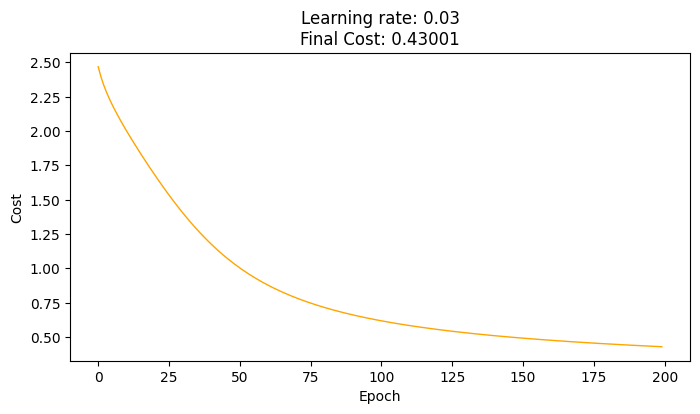

In [14]:
relu_model.cost_plot(learning_rate)

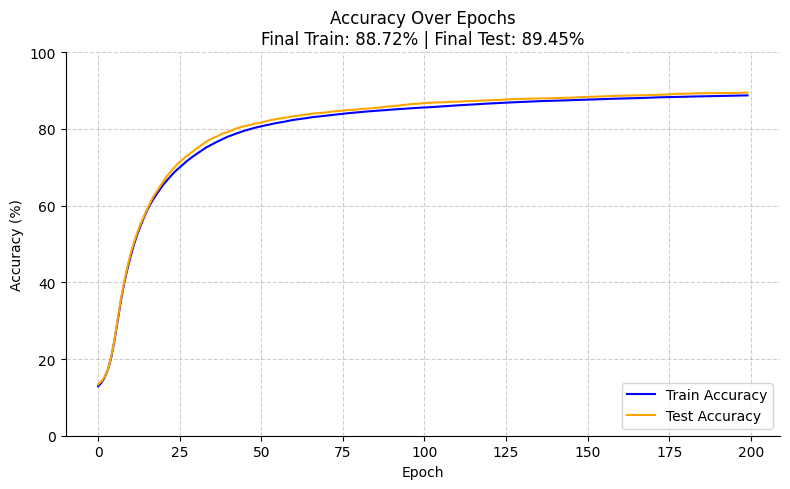

In [15]:
relu_model.accuracy_plot()

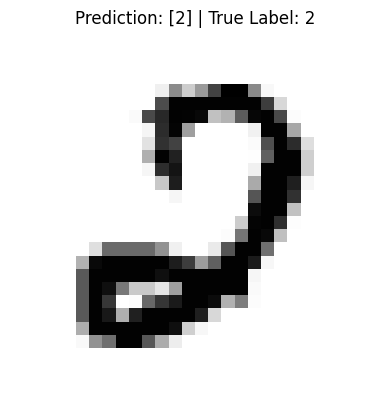

In [16]:
relu_model.test(400)

### Leaky Rectified Linear Unit Function

In [17]:
leaky_relu_model = NeuralNetwork(X_train, y_train, X_test, y_test, activation="leaky_relu", num_labels=10, architecture=[512, 300])

In [18]:
leaky_relu_model.fit(lr=learning_rate, epochs=epoch)

  0%|          | 1/200 [00:05<17:01,  5.13s/it]

Epoch:   0 | Cost: 2.355 | Accuracy: 12.348


  6%|▌         | 11/200 [00:49<13:57,  4.43s/it]

Epoch:  10 | Cost: 1.968 | Accuracy: 49.305


 10%|█         | 21/200 [01:31<12:23,  4.16s/it]

Epoch:  20 | Cost: 1.641 | Accuracy: 68.690


 16%|█▌        | 31/200 [02:13<11:43,  4.16s/it]

Epoch:  30 | Cost: 1.362 | Accuracy: 75.097


 20%|██        | 41/200 [02:56<11:33,  4.36s/it]

Epoch:  40 | Cost: 1.142 | Accuracy: 78.200


 26%|██▌       | 51/200 [03:37<10:19,  4.16s/it]

Epoch:  50 | Cost: 0.978 | Accuracy: 80.302


 30%|███       | 61/200 [04:20<09:41,  4.18s/it]

Epoch:  60 | Cost: 0.857 | Accuracy: 81.993


 36%|███▌      | 71/200 [05:02<09:05,  4.23s/it]

Epoch:  70 | Cost: 0.768 | Accuracy: 83.090


 40%|████      | 81/200 [05:43<08:08,  4.11s/it]

Epoch:  80 | Cost: 0.701 | Accuracy: 84.113


 46%|████▌     | 91/200 [06:25<07:30,  4.14s/it]

Epoch:  90 | Cost: 0.649 | Accuracy: 84.943


 50%|█████     | 101/200 [07:06<06:58,  4.22s/it]

Epoch: 100 | Cost: 0.607 | Accuracy: 85.647


 56%|█████▌    | 111/200 [07:47<06:02,  4.08s/it]

Epoch: 110 | Cost: 0.573 | Accuracy: 86.200


 60%|██████    | 121/200 [08:34<05:41,  4.32s/it]

Epoch: 120 | Cost: 0.545 | Accuracy: 86.668


 66%|██████▌   | 131/200 [09:15<04:49,  4.19s/it]

Epoch: 130 | Cost: 0.521 | Accuracy: 87.078


 70%|███████   | 141/200 [09:56<04:01,  4.10s/it]

Epoch: 140 | Cost: 0.501 | Accuracy: 87.398


 76%|███████▌  | 151/200 [10:39<03:23,  4.15s/it]

Epoch: 150 | Cost: 0.484 | Accuracy: 87.695


 80%|████████  | 161/200 [11:22<02:47,  4.29s/it]

Epoch: 160 | Cost: 0.469 | Accuracy: 87.937


 86%|████████▌ | 171/200 [12:04<02:01,  4.17s/it]

Epoch: 170 | Cost: 0.455 | Accuracy: 88.200


 90%|█████████ | 181/200 [12:48<01:20,  4.24s/it]

Epoch: 180 | Cost: 0.443 | Accuracy: 88.407


 96%|█████████▌| 191/200 [13:32<00:38,  4.33s/it]

Epoch: 190 | Cost: 0.433 | Accuracy: 88.593


100%|██████████| 200/200 [14:10<00:00,  4.25s/it]

Training terminated


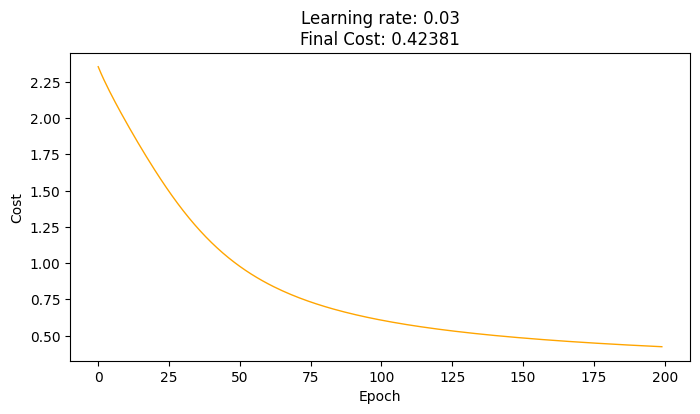

In [19]:
leaky_relu_model.cost_plot(learning_rate)

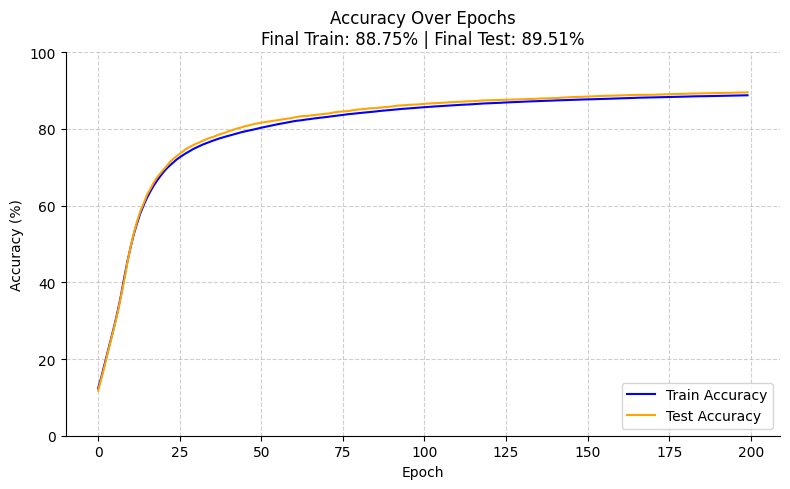

In [20]:
leaky_relu_model.accuracy_plot()

### Sigmoid Function

In [21]:
sigmoid_model = NeuralNetwork(X_train, y_train, X_test, y_test, activation="sigmoid", num_labels=10, architecture=[512, 300])

In [22]:
sigmoid_model.fit(lr=learning_rate, epochs=epoch)

  0%|          | 1/200 [00:08<29:27,  8.88s/it]

Epoch:   0 | Cost: 2.509 | Accuracy: 14.443


  6%|▌         | 11/200 [01:07<18:58,  6.02s/it]

Epoch:  10 | Cost: 2.291 | Accuracy: 13.287


 10%|█         | 21/200 [02:08<17:51,  5.98s/it]

Epoch:  20 | Cost: 2.284 | Accuracy: 14.415


 16%|█▌        | 31/200 [03:09<16:55,  6.01s/it]

Epoch:  30 | Cost: 2.276 | Accuracy: 15.735


 20%|██        | 41/200 [04:05<15:10,  5.73s/it]

Epoch:  40 | Cost: 2.268 | Accuracy: 17.507


 26%|██▌       | 51/200 [05:09<15:53,  6.40s/it]

Epoch:  50 | Cost: 2.261 | Accuracy: 19.972


 30%|███       | 61/200 [06:08<13:35,  5.86s/it]

Epoch:  60 | Cost: 2.253 | Accuracy: 23.037


 36%|███▌      | 71/200 [07:06<12:16,  5.71s/it]

Epoch:  70 | Cost: 2.246 | Accuracy: 26.650


 40%|████      | 81/200 [08:03<11:20,  5.72s/it]

Epoch:  80 | Cost: 2.238 | Accuracy: 30.512


 46%|████▌     | 91/200 [09:04<10:37,  5.85s/it]

Epoch:  90 | Cost: 2.230 | Accuracy: 34.378


 50%|█████     | 101/200 [10:17<12:07,  7.35s/it]

Epoch: 100 | Cost: 2.223 | Accuracy: 37.975


 56%|█████▌    | 111/200 [11:17<08:42,  5.87s/it]

Epoch: 110 | Cost: 2.215 | Accuracy: 41.270


 60%|██████    | 121/200 [12:15<07:29,  5.69s/it]

Epoch: 120 | Cost: 2.207 | Accuracy: 44.218


 66%|██████▌   | 131/200 [13:11<06:28,  5.64s/it]

Epoch: 130 | Cost: 2.199 | Accuracy: 46.757


 70%|███████   | 141/200 [14:09<05:34,  5.66s/it]

Epoch: 140 | Cost: 2.191 | Accuracy: 49.058


 76%|███████▌  | 151/200 [15:06<04:37,  5.66s/it]

Epoch: 150 | Cost: 2.182 | Accuracy: 51.000


 80%|████████  | 161/200 [16:03<03:41,  5.69s/it]

Epoch: 160 | Cost: 2.174 | Accuracy: 52.825


 86%|████████▌ | 171/200 [17:01<02:51,  5.93s/it]

Epoch: 170 | Cost: 2.165 | Accuracy: 54.365


 90%|█████████ | 181/200 [18:11<02:13,  7.04s/it]

Epoch: 180 | Cost: 2.157 | Accuracy: 55.750


 96%|█████████▌| 191/200 [19:18<01:00,  6.70s/it]

Epoch: 190 | Cost: 2.148 | Accuracy: 56.960


100%|██████████| 200/200 [20:17<00:00,  6.09s/it]

Training terminated


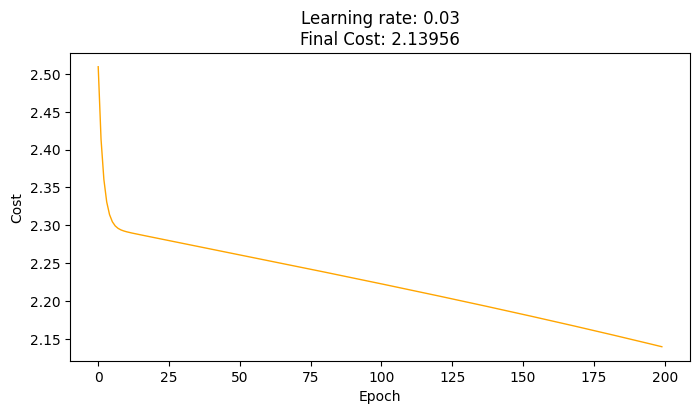

In [23]:
sigmoid_model.cost_plot(lr=learning_rate)

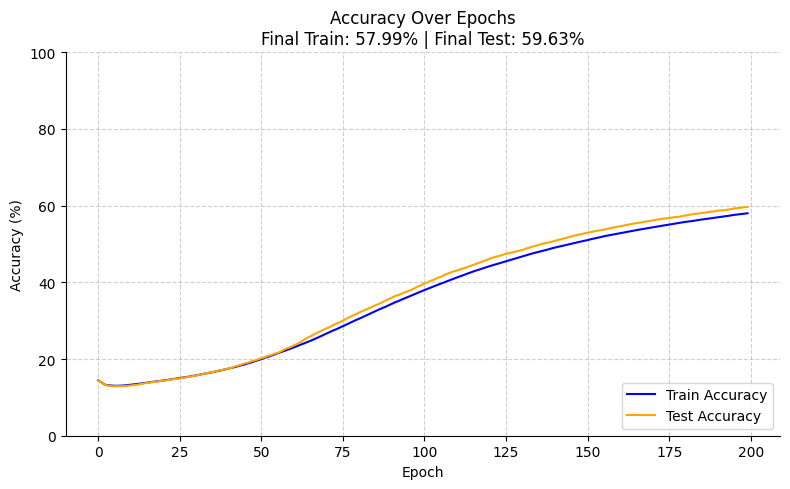

In [24]:
sigmoid_model.accuracy_plot()

### Tanh Function

In [25]:
tanh_model =  NeuralNetwork(X_train, y_train, X_test, y_test, activation="tanh", num_labels=10, architecture=[512, 300])

In [26]:
tanh_model.fit(lr=learning_rate, epochs=epoch)

  0%|          | 1/200 [00:07<24:17,  7.32s/it]

Epoch:   0 | Cost: 2.522 | Accuracy: 15.183


  6%|▌         | 11/200 [01:05<18:01,  5.72s/it]

Epoch:  10 | Cost: 1.520 | Accuracy: 63.848


 10%|█         | 21/200 [01:59<15:48,  5.30s/it]

Epoch:  20 | Cost: 1.131 | Accuracy: 74.775


 16%|█▌        | 31/200 [02:53<15:14,  5.41s/it]

Epoch:  30 | Cost: 0.929 | Accuracy: 79.305


 20%|██        | 41/200 [03:48<14:21,  5.42s/it]

Epoch:  40 | Cost: 0.807 | Accuracy: 81.582


 26%|██▌       | 51/200 [04:42<13:35,  5.47s/it]

Epoch:  50 | Cost: 0.726 | Accuracy: 82.990


 30%|███       | 61/200 [05:41<14:45,  6.37s/it]

Epoch:  60 | Cost: 0.667 | Accuracy: 83.938


 36%|███▌      | 71/200 [06:45<13:31,  6.29s/it]

Epoch:  70 | Cost: 0.623 | Accuracy: 84.693


 40%|████      | 81/200 [07:50<12:59,  6.55s/it]

Epoch:  80 | Cost: 0.589 | Accuracy: 85.303


 46%|████▌     | 91/200 [08:46<10:08,  5.58s/it]

Epoch:  90 | Cost: 0.561 | Accuracy: 85.828


 50%|█████     | 101/200 [09:43<09:27,  5.73s/it]

Epoch: 100 | Cost: 0.538 | Accuracy: 86.268


 56%|█████▌    | 111/200 [10:39<08:09,  5.50s/it]

Epoch: 110 | Cost: 0.518 | Accuracy: 86.622


 60%|██████    | 121/200 [11:34<07:13,  5.49s/it]

Epoch: 120 | Cost: 0.502 | Accuracy: 86.925


 66%|██████▌   | 131/200 [12:29<06:11,  5.38s/it]

Epoch: 130 | Cost: 0.487 | Accuracy: 87.235


 70%|███████   | 141/200 [13:23<05:16,  5.36s/it]

Epoch: 140 | Cost: 0.475 | Accuracy: 87.497


 76%|███████▌  | 151/200 [14:17<04:22,  5.35s/it]

Epoch: 150 | Cost: 0.463 | Accuracy: 87.737


 80%|████████  | 161/200 [15:13<03:33,  5.47s/it]

Epoch: 160 | Cost: 0.453 | Accuracy: 87.958


 86%|████████▌ | 171/200 [16:08<02:40,  5.55s/it]

Epoch: 170 | Cost: 0.444 | Accuracy: 88.138


 90%|█████████ | 181/200 [17:01<01:43,  5.43s/it]

Epoch: 180 | Cost: 0.436 | Accuracy: 88.283


 96%|█████████▌| 191/200 [17:57<00:53,  5.90s/it]

Epoch: 190 | Cost: 0.428 | Accuracy: 88.435


100%|██████████| 200/200 [18:45<00:00,  5.63s/it]

Training terminated


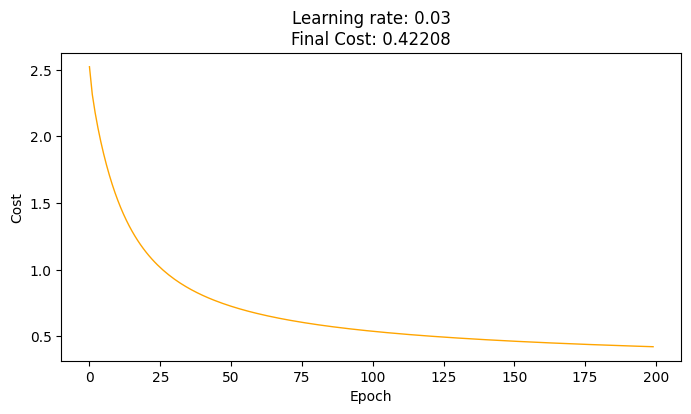

In [27]:
tanh_model.cost_plot(lr=learning_rate)

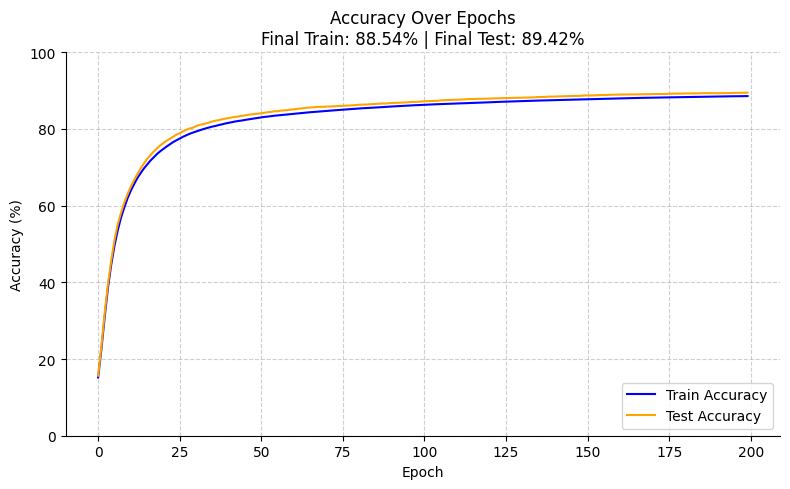

In [29]:
tanh_model.accuracy_plot()

## Testing Models

In [62]:
def plot_predictions(model, X_test, labels, rows, cols):
    indexes = np.random.choice(range(X_test.shape[1]), rows * cols)
    fig, ax = plt.subplots(rows, cols, figsize=(5, 4))
    n = 0
    for i in range(rows):
        for j in range(cols):
            ix = indexes[n]
            example = X_test[:, ix].reshape(28,28)
            prediction = model.predict(X_test[:, ix].reshape((X_test[:, ix].shape[0], 1)))
            subplot = ax[i, j]
            if labels.ndim == 1:
                true_label = labels[ix]
            else:
                true_label = np.argmax(labels[:, ix])
            subplot.set_title(f"Prediction: {prediction}\nLabel: {true_label}")
            subplot.imshow(example, cmap="Greys")
            subplot.axis('off')
            n += 1
    plt.tight_layout()
    plt.show()

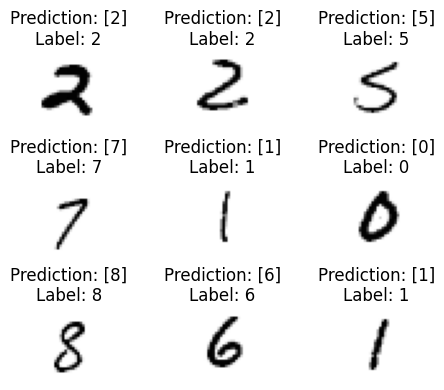

In [66]:
plot_predictions(relu_model, X_test, y_test, 3, 3)

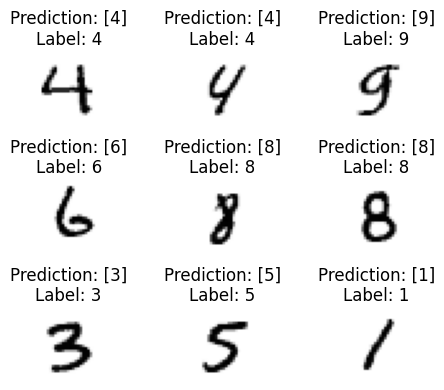

In [40]:
plot_predictions(leaky_relu_model, X_test, y_test, 3, 3)

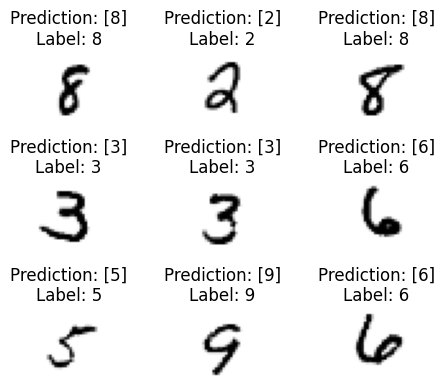

In [47]:
plot_predictions(tanh_model, X_test, y_test, 3, 3)

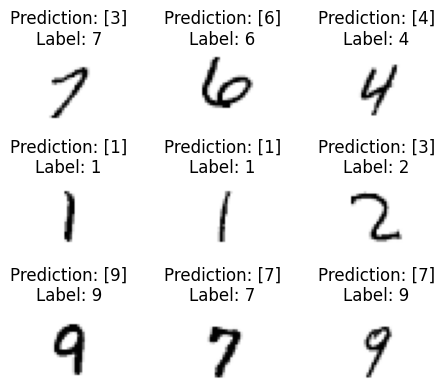

In [46]:
plot_predictions(sigmoid_model, X_test, y_test, 3, 3)